In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

# Load data
file_path = "/content/drive/MyDrive/DRF P1/Combined Data.csv"
df = pd.read_csv(file_path)

# Clean unwanted columns
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Remove missing or duplicate rows
df = df.dropna(subset=['statement']).drop_duplicates(subset='statement')
print(f"✅ Cleaned dataset shape: {df.shape}")


✅ Cleaned dataset shape: (51073, 2)


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and t.isalpha()]
    lemmas = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
    return " ".join(lemmas)

df["processed_text"] = df["statement"].astype(str).apply(clean_text)
print("✅ Sample processed text:")
print(df[["statement", "processed_text", "status"]].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Sample processed text:
                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                      processed_text   status  
0                                            oh gosh  Anxiety  
1     trouble sleep confuse mind restless heart tune  Anxiety  
2  wrong back dear forward doubt stay restless re...  Anxiety  
3      ive shift focus something else im still worry  Anxiety  
4                im restless restless month boy mean  Anxiety  


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["encoded_status"] = le.fit_transform(df["status"])
print("✅ Encoded labels:\n", pd.DataFrame({"Label": le.classes_, "Encoded": range(len(le.classes_))}))


✅ Encoded labels:
                   Label  Encoded
0               Anxiety        0
1               Bipolar        1
2            Depression        2
3                Normal        3
4  Personality disorder        4
5                Stress        5
6              Suicidal        6


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X = tfidf.fit_transform(df["processed_text"])
y = df["encoded_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Training samples:", X_train.shape[0])
print("✅ Testing samples:", X_test.shape[0])


✅ Training samples: 40858
✅ Testing samples: 10215



🔹 Training Naive Bayes...
✅ Naive Bayes Accuracy: 0.68
                      precision    recall  f1-score   support

             Anxiety       0.78      0.68      0.73       723
             Bipolar       0.84      0.53      0.65       500
          Depression       0.56      0.76      0.65      3018
              Normal       0.80      0.83      0.82      3208
Personality disorder       0.93      0.08      0.14       179
              Stress       0.68      0.11      0.18       459
            Suicidal       0.69      0.56      0.62      2128

            accuracy                           0.68     10215
           macro avg       0.75      0.51      0.54     10215
        weighted avg       0.70      0.68      0.67     10215



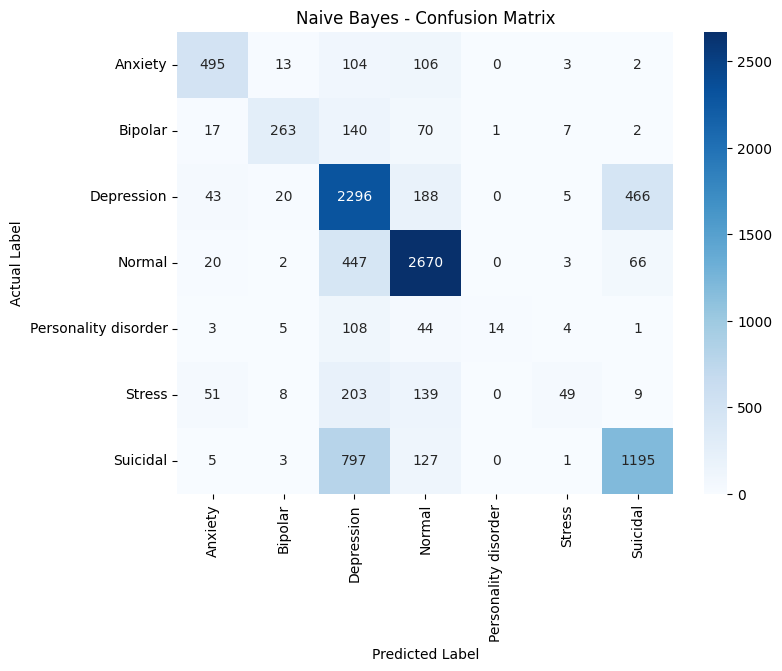

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n🔹 Training Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

nb_acc = accuracy_score(y_test, nb_preds)
print(f"✅ Naive Bayes Accuracy: {nb_acc:.2f}")
print(classification_report(y_test, nb_preds, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, nb_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


In [9]:
from sklearn.ensemble import RandomForestClassifier

print("\n🔹 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_preds)
print(f"✅ Random Forest Accuracy: {rf_acc:.2f}")
print(classification_report(y_test, rf_preds, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()



🔹 Training Random Forest...


KeyboardInterrupt: 


🔹 Training SVM...
✅ SVM Accuracy: 0.75
                      precision    recall  f1-score   support

             Anxiety       0.79      0.78      0.78       723
             Bipolar       0.80      0.71      0.75       500
          Depression       0.70      0.68      0.69      3018
              Normal       0.84      0.95      0.89      3208
Personality disorder       0.66      0.44      0.52       179
              Stress       0.62      0.41      0.49       459
            Suicidal       0.64      0.63      0.64      2128

            accuracy                           0.75     10215
           macro avg       0.72      0.65      0.68     10215
        weighted avg       0.74      0.75      0.74     10215



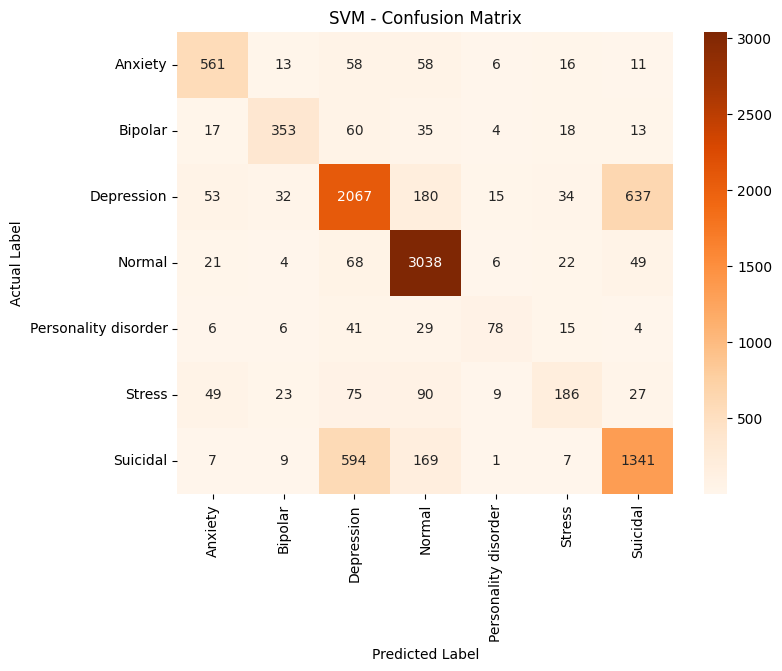

In [10]:
from sklearn.svm import LinearSVC

print("\n🔹 Training SVM...")
svm_model = LinearSVC(max_iter=3000, random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

svm_acc = accuracy_score(y_test, svm_preds)
print(f"✅ SVM Accuracy: {svm_acc:.2f}")
print(classification_report(y_test, svm_preds, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np

# 🔹 Tokenize the processed text
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df["processed_text"])

X_seq = tokenizer.texts_to_sequences(df["processed_text"])
max_len = 100
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# 🔹 Split into train-test
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(
    X_pad, df["encoded_status"], test_size=0.2, random_state=42, stratify=df["encoded_status"]
)

# 🔹 Convert to categorical (one-hot encoding)
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_pad, num_classes=num_classes)
y_test_cat = to_categorical(y_test_pad, num_classes=num_classes)

# 🔹 Compute class weights (to handle imbalance)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_pad), y=y_train_pad)
cw_dict = dict(enumerate(class_weights))
print("⚖️ Class Weights:", cw_dict)


⚖️ Class Weights: {0: np.float64(2.0168822193701255), 1: np.float64(2.916970086385379), 2: np.float64(0.483623924339808), 3: np.float64(0.4549027466960598), 4: np.float64(8.152035115722267), 5: np.float64(3.182582956846861), 6: np.float64(0.6856404490610998)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



🔹 Training LSTM...
Epoch 1/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 188s 315ms/step - accuracy: 0.2525 - loss: 1.9007 - val_accuracy: 0.3399 - val_loss: 1.8430
Epoch 2/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 198s 309ms/step - accuracy: 0.3334 - loss: 1.8060 - val_accuracy: 0.3921 - val_loss: 1.3987
Epoch 3/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 175s 304ms/step - accuracy: 0.4654 - loss: 1.5597 - val_accuracy: 0.5526 - val_loss: 0.9889
Epoch 4/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 175s 303ms/step - accuracy: 0.5758 - loss: 1.2673 - val_accuracy: 0.6557 - val_loss: 0.8990
Epoch 5/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 202s 303ms/step - accuracy: 0.6611 - loss: 0.9922 - val_accuracy: 0.7026 - val_loss: 0.7707
Epoch 6/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 175s 304ms/step - accuracy: 0.7176 - loss: 0.7575 - val_accuracy: 0.7225 - val_loss: 0.7523
Epoch 7/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 174s 301ms/step - accuracy: 0.7454 - loss: 0.6270 - val_accuracy: 0.7220 - val_loss: 0.7582
Epoch 8/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 174s 302ms/step 

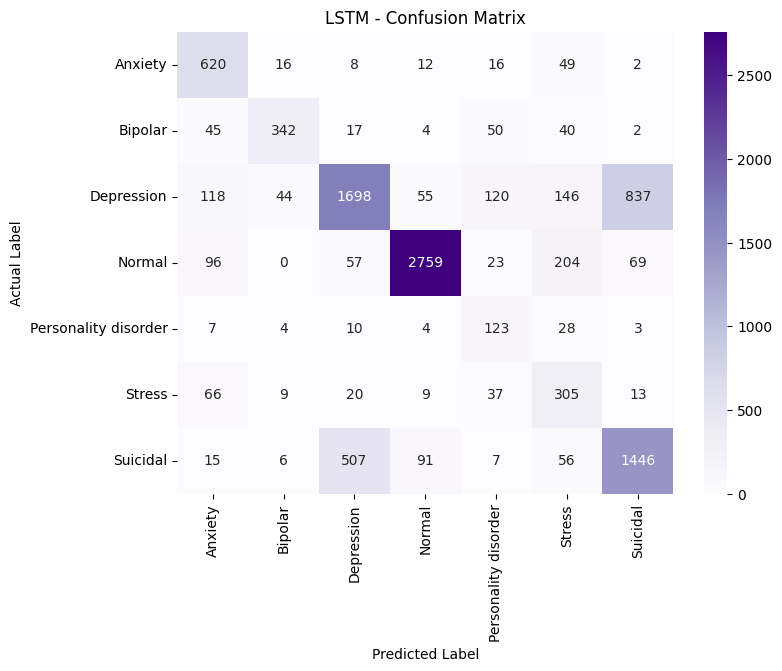

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 🧠 Define LSTM architecture
model_lstm = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 🛑 Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🔹 Train LSTM
print("\n🔹 Training LSTM...")
history_lstm = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=15, batch_size=64,
    validation_split=0.1,
    class_weight=cw_dict,
    callbacks=[early_stop]
)

# 🔍 Evaluate LSTM
lstm_preds = model_lstm.predict(X_test_pad)
lstm_pred_classes = np.argmax(lstm_preds, axis=1)
lstm_acc = accuracy_score(y_test_pad, lstm_pred_classes)

print(f"✅ LSTM Accuracy: {lstm_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_pad, lstm_pred_classes, target_names=le.classes_))

# 📊 Confusion Matrix
cm_lstm = confusion_matrix(y_test_pad, lstm_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



🔹 Training GRU (Fast Mode)...
Epoch 1/6
575/575 ━━━━━━━━━━━━━━━━━━━━ 164s 273ms/step - accuracy: 0.2960 - loss: 1.8632 - val_accuracy: 0.6094 - val_loss: 0.9649
Epoch 2/6
575/575 ━━━━━━━━━━━━━━━━━━━━ 157s 272ms/step - accuracy: 0.6499 - loss: 1.0155 - val_accuracy: 0.7230 - val_loss: 0.7220
Epoch 3/6
575/575 ━━━━━━━━━━━━━━━━━━━━ 202s 273ms/step - accuracy: 0.7288 - loss: 0.7181 - val_accuracy: 0.7403 - val_loss: 0.7068
Epoch 4/6
575/575 ━━━━━━━━━━━━━━━━━━━━ 154s 268ms/step - accuracy: 0.7566 - loss: 0.5975 - val_accuracy: 0.7484 - val_loss: 0.6781
Epoch 5/6
575/575 ━━━━━━━━━━━━━━━━━━━━ 202s 268ms/step - accuracy: 0.7846 - loss: 0.4781 - val_accuracy: 0.7592 - val_loss: 0.6471
Epoch 6/6
575/575 ━━━━━━━━━━━━━━━━━━━━ 202s 267ms/step - accuracy: 0.8017 - loss: 0.4126 - val_accuracy: 0.7509 - val_loss: 0.6834
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step
✅ GRU Accuracy: 0.76

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.75

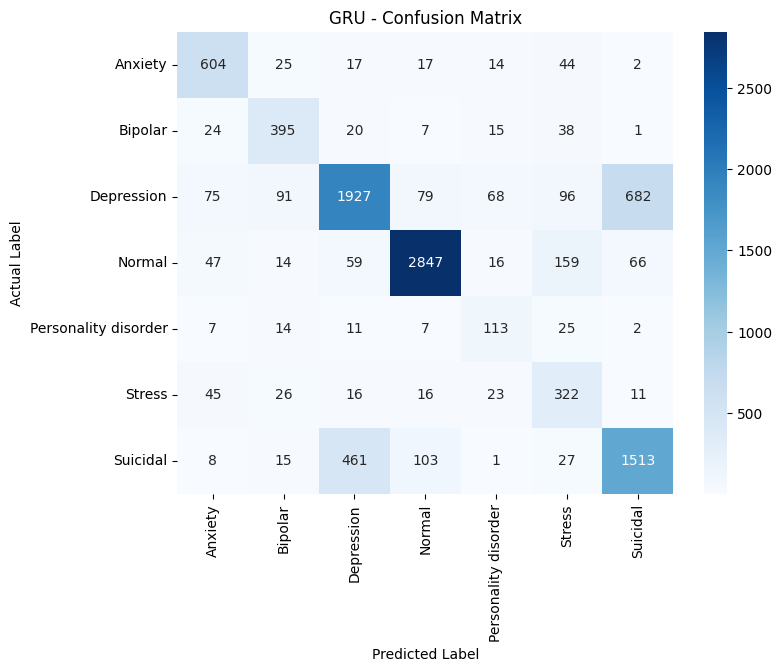

In [14]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 🧠 Define GRU architecture
model_gru = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    GRU(128, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 🛑 Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 🔹 Train GRU (Reduced Epochs for Speed)
print("\n🔹 Training GRU (Fast Mode)...")
history_gru = model_gru.fit(
    X_train_pad, y_train_cat,
    epochs=6, batch_size=64,          # 👈 Reduced from 15 → 6
    validation_split=0.1,
    class_weight=cw_dict,
    callbacks=[early_stop],
    verbose=1
)

# 🔍 Evaluate GRU
gru_preds = model_gru.predict(X_test_pad)
gru_pred_classes = np.argmax(gru_preds, axis=1)
gru_acc = accuracy_score(y_test_pad, gru_pred_classes)

print(f"✅ GRU Accuracy: {gru_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_pad, gru_pred_classes, target_names=le.classes_))

# 📊 Confusion Matrix
cm_gru = confusion_matrix(y_test_pad, gru_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("GRU - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


In [15]:
new_texts = [
    "My heart keeps racing and I can’t calm down.",
    "Yesterday I was full of energy, today I feel nothing.",
    "Everything feels hopeless and meaningless.",
    "I just finished lunch and feel relaxed.",
    "Sometimes I lose track of who I really am.",
    "Deadlines are killing me; I can’t handle this pressure.",
    "I don’t want to live anymore, everything feels dark."
]

seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=max_len, padding='post')

# Choose model (either GRU or LSTM)
pred_probs = model_gru.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
pred_labels = le.inverse_transform(pred_classes)

pd.DataFrame({"Statement": new_texts, "Predicted Label": pred_labels})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


,Statement,Predicted Label
0,My heart keeps racing and I can’t calm down.,Normal
1,"Yesterday I was full of energy, today I feel n...",Depression
2,Everything feels hopeless and meaningless.,Suicidal
3,I just finished lunch and feel relaxed.,Normal
4,Sometimes I lose track of who I really am.,Normal
5,Deadlines are killing me; I can’t handle this ...,Normal
6,"I don’t want to live anymore, everything feels...",Suicidal


Improve GRU Accuracy and Balance

Balance the Dataset Before Training

In [17]:
from sklearn.utils import resample

print("Before balancing:\n", df["status"].value_counts())

# 🔹 Create an empty list to store balanced data
balanced_dfs = []
max_size = df["status"].value_counts().max()  # largest class size (Normal)

# 🔹 Upsample each class to match max_size
for label in df["status"].unique():
    df_class = df[df["status"] == label]
    df_upsampled = resample(
        df_class,
        replace=True,
        n_samples=max_size,
        random_state=42
    )
    balanced_dfs.append(df_upsampled)

# 🔹 Combine them all
df_balanced = pd.concat(balanced_dfs)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ After full balancing:\n", df_balanced["status"].value_counts())


Before balancing:
 status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

✅ After full balancing:
 status
Personality disorder    16039
Bipolar                 16039
Stress                  16039
Normal                  16039
Depression              16039
Suicidal                16039
Anxiety                 16039
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.layers import GRU, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Encode labels again (to ensure correct mapping)
df = df_balanced.copy()
le = LabelEncoder()
df['encoded_status'] = le.fit_transform(df['status'])

# Tokenize and pad
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["processed_text"])

X_seq = tokenizer.texts_to_sequences(df["processed_text"])
max_len = 100
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

y = df["encoded_status"]
num_classes = len(le.classes_)

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)

y_train_cat = to_categorical(y_train_pad, num_classes=num_classes)
y_test_cat = to_categorical(y_test_pad, num_classes=num_classes)

# 🧠 Define GRU model
model_gru = Sequential([
    Embedding(5000, 128, input_length=max_len),
    GRU(128, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 🛑 Early stopping — prevents overfitting even if you set more epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🚀 Train GRU
print("\n🔹 Training GRU on balanced dataset (15 Epochs)...")
history_gru = model_gru.fit(
    X_train_pad, y_train_cat,
    epochs=15, batch_size=64,          # 👈 Increased to 15
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# 🔍 Evaluate
gru_preds = model_gru.predict(X_test_pad)
gru_pred_classes = np.argmax(gru_preds, axis=1)
gru_acc = accuracy_score(y_test_pad, gru_pred_classes)

print(f"\n✅ GRU Accuracy (Balanced Data): {gru_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_pad, gru_pred_classes, target_names=le.classes_))

# 📊 Confusion Matrix
cm_gru = confusion_matrix(y_test_pad, gru_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("GRU Model - Confusion Matrix (Balanced Data, 15 Epochs)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()



🔹 Training GRU on balanced dataset (15 Epochs)...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 551/1264 ━━━━━━━━━━━━━━━━━━━━ 3:08 265ms/step - accuracy: 0.2436 - loss: 1.8036